## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [3]:
import hw

## Load data

In [4]:
cropped_data_dir = 'data/CroppedYale/'
cropped = hw.LoadCropped(cropped_data_dir)

In [5]:
h = cropped.h
w = cropped.w

# Plot first image for each subject

In [6]:
face_images_list = hw.get_first_face_per_dir(cropped.face_dirs)
image_arrays = hw.load_images(face_images_list)

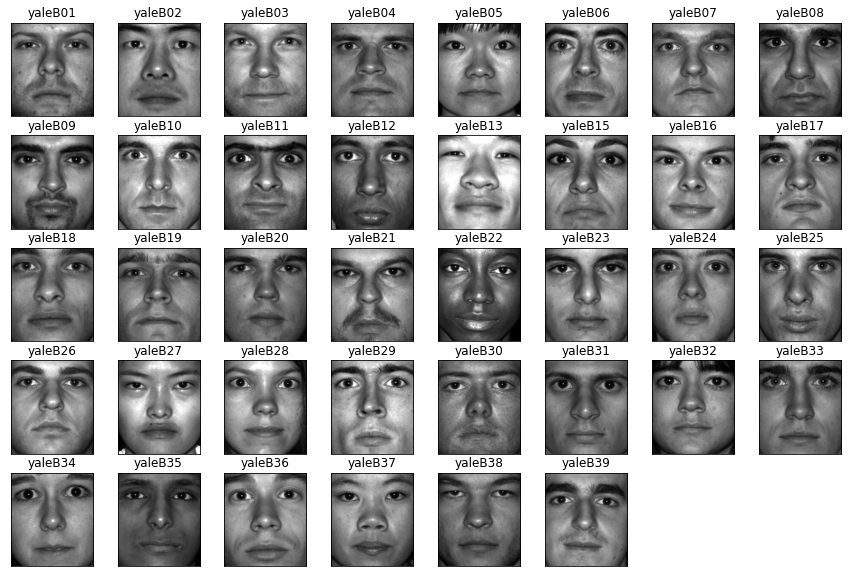

In [7]:
hw.plot_images_subset(image_arrays,
                       rows = 5,
                       columns = 8,
                       figsize= (15,10),
                       labels = cropped.target_names)

## Subjectively assign gender labels

In [8]:
gender_labels = np.array(['male', 'male','male','male','female','male','male','male',
                 'male','male','male','male','male','female','male','male',
                 'male','male','male','male','female','male','male','male',
                 'male','female','female','male','male','male','female','male',
                 'female','male','male','female','male','male'])

In [9]:
faces_dict = dict(zip(cropped.target_names, cropped.faces))
for i,v in enumerate(faces_dict):
    faces_dict[v] = [faces_dict[v],gender_labels[i]]
    
female_indices = []
females = []
males = []
male_indices = []
for key, value in faces_dict.items():
    if value[1] == 'male':
        males.append(value[0])
        for i in value[0].T:
            male_indices.append(0)
            
    else:
        females.append(value[0])
        for i in value[0].T:
            female_indices.append(1)
            
females = np.hstack(females).T
males = np.hstack(males).T

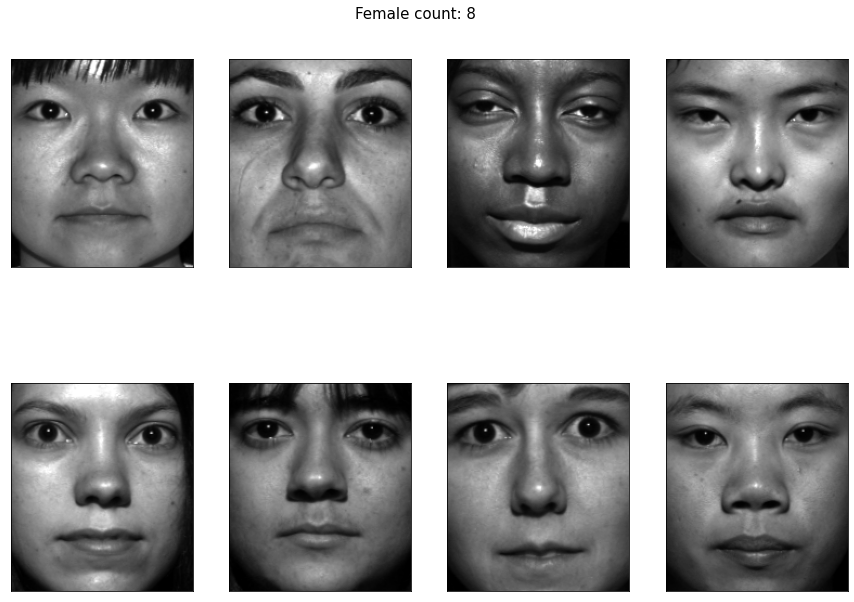

In [10]:
title = 'Female count: ' + str(len(gender_labels[gender_labels == 'female']))
            
hw.plot_images_subset(females[::64], 
                      rows = 2,
                      columns = 4,
                      reshape=(h,w),
                      figsize=(15, 10),
                      title = title )

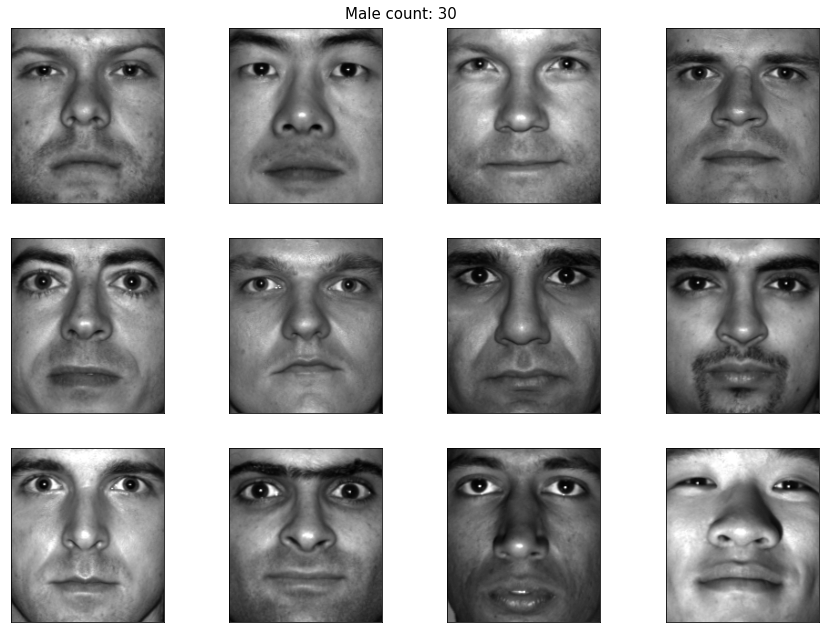

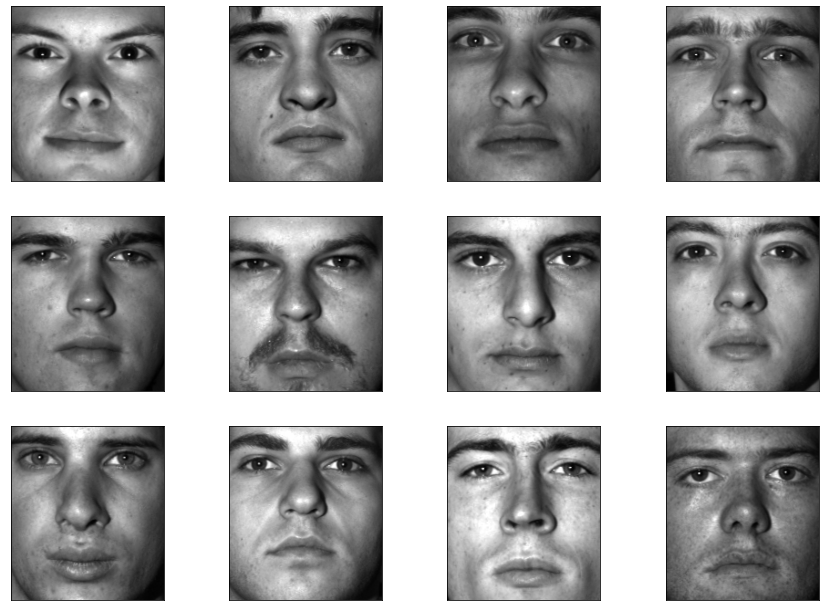

In [11]:
title = 'Male count: ' + str(len(gender_labels[gender_labels == 'male']))
            
hw.plot_images_subset(males[:705:64], 
                      rows = 3,
                      columns = 4,
                      reshape=(h,w),
                      figsize=(15, 10),
                      title = title )

hw.plot_images_subset(males[759::64], 
                      rows = 3,
                      columns = 4,
                      reshape=(h,w),
                      figsize=(15, 10),
                      title= '')

## Stage data

In [12]:
X             = np.vstack([males,females])
y             = np.hstack([male_indices, female_indices])
target_names  = np.array(['males','female'])
n_samples     = cropped.n_samples
n_features    = cropped.n_features
n_classes     = 2

## Split into training and test data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Compute rank r truncation

In [14]:
U,S,VT = np.linalg.svd(X_train.T,full_matrices=0) 

In [15]:
var_explained = np.round(S**2/np.sum(S**2), decimals=100)
thresh = 0.99
cdf=np.cumsum(var_explained)
n_components = np.where(cdf>thresh)[0][0]
n_components

135

## Compute eigenfaces and project images into subspace

In [16]:
pca = PCA(n_components=n_components, 
          svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## K-Nearest Neighbors

In [17]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 2, 3, 5, 10, 50], }

model = KNeighborsClassifier(n_jobs=-1)

## Cross-Validation

In [18]:
clf = GridSearchCV(model, param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Score: %0.2f" % clf.best_score_)

Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')
Score: 0.97


## Predict

In [19]:
y_pred = clf.predict(X_test_pca)

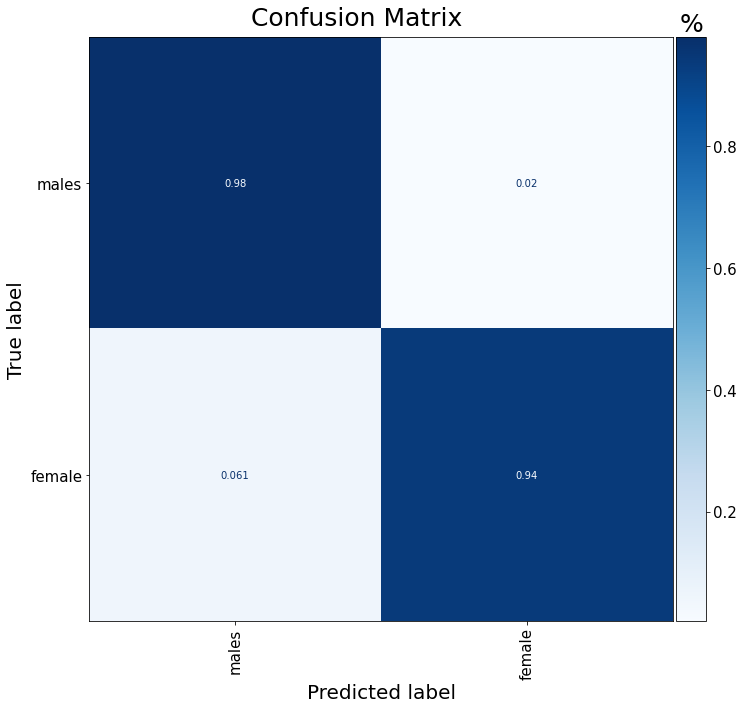

In [26]:
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

plt.savefig('plots/gender/gender_confusion_matrix.png');

## Plot hits and misses

In [21]:
hits = X_test[(y_pred == y_test)]
misses = X_test[(y_pred != y_test)]

In [22]:
len(misses)

17

In [29]:
len(hits)

587

In [30]:
len(hits) + len(misses)

604

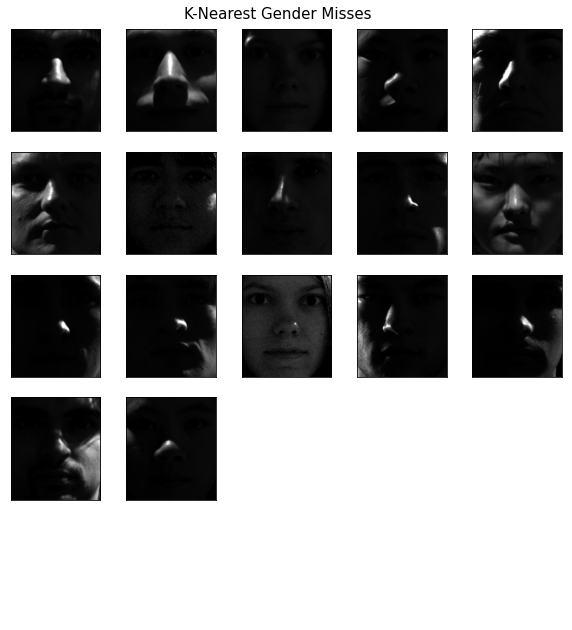

In [28]:
hw.plot_images_subset(misses,
                       rows = 5,
                       columns = 5,
                       figsize= (10,10),
                       reshape = (h,w),
                       title = "K-Nearest Gender Misses")

plt.savefig('plots/gender/misses.png')